# Лабораторная работа №4

## В данной работе мы построим интерполянт Ньютона для данных о населении США за ХХ век, а также про экстраполируем эти данные с помощью интерполянта Ньютона и сплайна

## Импортируем необходимые библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk
from IPython.display import display, Latex
from prettytable import PrettyTable

## Запишем данные о населении США:

In [2]:
population = np.array([[92_228_496,  1910],
                       [106_021_537, 1920],
                       [123_202_624, 1930],
                       [132_164_569, 1940],
                       [151_325_798, 1950],
                       [179_323_175, 1960],
                       [203_211_926, 1970],
                       [226_545_805, 1980],
                       [248_709_873, 1990],
                       [281_421_906, 2000]])

populationTable = PrettyTable(["Численность", "Год"])
populationTable.add_rows(population)
print(populationTable)

+-------------+------+
| Численность | Год  |
+-------------+------+
|   92228496  | 1910 |
|  106021537  | 1920 |
|  123202624  | 1930 |
|  132164569  | 1940 |
|  151325798  | 1950 |
|  179323175  | 1960 |
|  203211926  | 1970 |
|  226545805  | 1980 |
|  248709873  | 1990 |
|  281421906  | 2000 |
+-------------+------+


# Полином Ньютона

## Выпишем формулу для рассчета разделенной разности:

In [3]:
def separated_diff (data):
    keeper = []
    keeper.append(list(data[:, 0]))
    
    for i in range (len(data)):
        keeper.append([(keeper[i][j+1] - keeper[i][j]) / (data[j + i + 1][1] - data[j][1]) for j in range(len(data) - i - 1)])
    
    return keeper[:-1]

sep_diff = separated_diff(population)

## Теперь напишем функцию для рассчета значения полинома Ньютона в заданной точке:

In [4]:
def Newtow_Inter_value (data, point):
    coefs = separated_diff(data)
    
    value = coefs[0][0]
    polinom_part = 1

    for i in range(len(coefs)- 1):
        polinom_part *= (point - data[i][1])
        value += coefs[i+1][0]*polinom_part
    return value

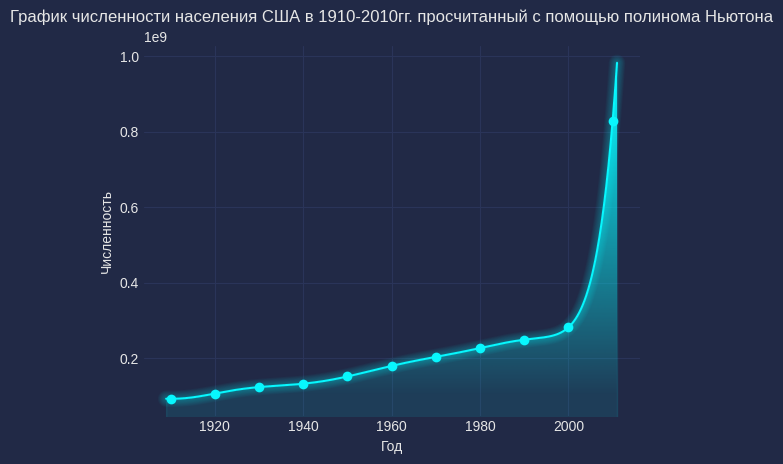

In [5]:
x = np.linspace (1909, 2011, num=1000)

plt.style.use("cyberpunk")

plt.title(r'График численности населения США в 1910-2010гг. просчитанный с помощью полинома Ньютона')
plt.plot(x, Newtow_Inter_value(population, x))
plt.scatter(np.append(population[:, 1], 2010), Newtow_Inter_value(population, np.append(population[:, 1], 2010)), marker='o', )
plt.xlabel('Год')
plt.ylabel('Численность')

mplcyberpunk.add_glow_effects()
mplcyberpunk.add_gradient_fill(alpha_gradientglow=1.0)
plt.show()

In [6]:
pop2010_fake = Newtow_Inter_value(population, 2010)
pop2010_real = 308_745_538
print('Экстраполированная таким методом численность населения США в 2010 году равна: ', int(pop2010_fake))
print('Что совершенно не сходится с наблюдавшимся значением 308745538, погрешность получилась:', 
      str(int(100 * (pop2010_fake - pop2010_real)/pop2010_real)) + '%')

Экстраполированная таким методом численность населения США в 2010 году равна:  827906509
Что совершенно не сходится с наблюдавшимся значением 308745538, погрешность получилась: 168%


# Сплайн-аппроксимация

## Будет интерполировать и экстраполировать используя кубический сплайн. И просчитаем коэффициенты с помощью метода трехдиагональной прогонки.

In [7]:
class Spline:
    def __init__(self, a, rb):
        self.a = a
        self.b = 0
        self.c = 0
        self.d = 0
        self.right_border = rb
    
def getCubeSpline(data):
    x = [data[i, 1] for i in range (len(data))]
    y = [data[i, 0] for i in range (len(data))]
    n = len(data)
    
    splines = [Spline(*elem) for elem in data]

    h = [data[i + 1, 1] - data[i, 1] for i in range(n - 1)]
    deltaY = [data[i + 1, 0] - data[i, 0] for i in range(n - 1)]
    
    alpha = [0]
    beta = [0]
    
    for i in range(1,n - 1):
        z = h[i - 1] * (alpha[i - 1] + 2) + 2 * h[i]
        alpha.append(- h[i] / z)
        beta.append((6.0 * (deltaY[i] / h[i] - deltaY[i - 1] / h[i - 1]) - h[i - 1] * beta[i - 1]) / z)
    
    for i in range(n - 2, 0, -1):
        splines[i].c = alpha[i] * splines[i + 1].c + beta[i]
    
    for i in range(n - 1, 0, -1):
        splines[i].d = (splines[i].c - splines[i - 1].c) / h[i - 1]
        splines[i].b = h[i - 1] * (2.0 * splines[i].c + splines[i - 1].c) / 6.0 + deltaY[i - 1] / h[i - 1]
    
    return splines

def getCubeSplineValue(splines, x):
    n = len(splines)
    s = splines[1]
    
    if x <= splines[0].right_border:
        s = splines[0]
    elif x >= splines[n - 1].right_border:
        s = splines[n - 1]
    else:
        i = 0
        j = n - 1
        while i + 1 < j:
            k = i + (j - i) // 2
            if x <= splines[k].right_border:
                j = k
            else:
                i = k
        s = splines[j]
    dx = x - s.right_border
    return s.a + s.b * dx + s.c / 2 * dx ** 2 + 1 / 6 * s.d * dx ** 3

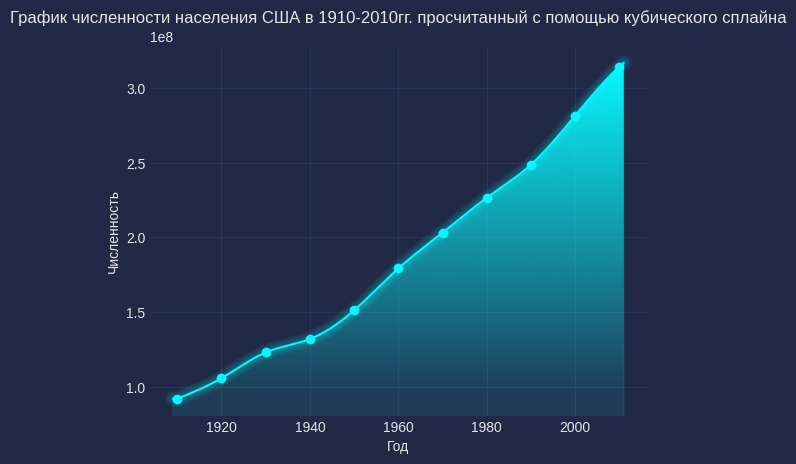

In [8]:
x = np.linspace (1909, 2011, num=1000)
spl = getCubeSpline(population)

plt.title(r'График численности населения США в 1910-2010гг. просчитанный с помощью кубического сплайна')
plt.plot(x, list(map (lambda el: getCubeSplineValue(spl, el), x)))
plt.scatter(np.append(population[:, 1], 2010), list(map (lambda el: getCubeSplineValue(spl, el), np.append(population[:, 1], 2010))), marker='o')
plt.xlabel('Год')
plt.ylabel('Численность')

mplcyberpunk.add_glow_effects()
mplcyberpunk.add_gradient_fill(alpha_gradientglow=1.0)
plt.show()

In [9]:
pop2010_fake = getCubeSplineValue(spl, 2010)
pop2010_real = 308_745_538
print('Экстраполированная таким методом численность населения США в 2010 году равна: ', int(pop2010_fake))
print('Что сходится с наблюдавшимся значением 308745538, погрешность получилась:', 
      str(100 * (pop2010_fake - pop2010_real)/pop2010_real)[:3] + '%')

Экстраполированная таким методом численность населения США в 2010 году равна:  314133939
Что сходится с наблюдавшимся значением 308745538, погрешность получилась: 1.7%
